In [1]:
import os
import json
import numpy as np
import shutil
import argparse
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms

import subprocess
if not os.path.exists("Japanese_BPEEncoder_V2"):
    subprocess.run(["git", "clone", "https://github.com/tanreinama/Japanese-BPEEncoder_V2.git", "Japanese_BPEEncoder_V2"])
from Japanese_BPEEncoder_V2.encode_swe import SWEEncoder_ja

In [9]:
# # コマンドライン引数の処理
# parser = argparse.ArgumentParser(description="設定用プログラム")

# parser.add_argument("--num_workers", type = int, default = 16, help = "データローダが使用するCPUのスレッド数(GPUの総スレッド数の8割が推奨)")
# parser.add_argument("--reset_data", action = "store_true", help = "データセットを再作成するか")
# parser.add_argument("--retrain_autoencoder", action = "store_true", help = "Autoencoderを再学習するか")
# parser.add_argument("--use_unreal_image", action = "store_true", help = "現実写真以外を使用する")
# parser.add_argument("--use_word_image", action = "store_true", help = "文字を含む画像を使用する")
# parser.add_argument("--use_unique_noun_boke", action = "store_true", help = "固有名詞を含む大喜利を使用する")
# parser.add_argument("--min_star", type = int, default = 0, help = "大喜利の最小の星の数")
# parser.add_argument("--min_apper_word", type = int, default = 32, help = "単語の最小出現回数")
# parser.add_argument("--min_sentence_length", type = int, default = 4, help = "大喜利の最小単語数")
# parser.add_argument("--max_sentence_length", type = int, default = 31, help = "大喜利の最大単語数")
# parser.add_argument("--image_height", type = int, default = 4, help = "画像の高さ")
# parser.add_argument("--image_width", type = int, default = 4, help = "画像の幅")
# parser.add_argument("--ae_feature_dim", type = int, default = 4, help = "AEの特徴量次元数")
# parser.add_argument("--ae_epoch", type = int, default = 25, help = "AEの学習反復回数")
# parser.add_argument("--ae_batch_size", type = int, default = 512, help = "AEのバッチサイズ")
# parser.add_argument("--ae_learning_rate", type = float, default = 0.001, help = "AEの学習率")
# parser.add_argument("--epoch", type = int, default = 25, help = "学習反復回数")
# parser.add_argument("--batch_size", type = int, default = 512, help = "バッチサイズ")
# parser.add_argument("--learning_rate", type = float, default = 0.001, help = "学習率")
# parser.add_argument("--feature_dim", type = int, default = 1024, help = "モデルの特徴量次元数")

# args = parser.parse_args()

In [2]:
NUM_WORKERS = 16 # args.num_workers
RESET_DATA = False # args.reset_data

USE_UNREAL_IMAGE = False # args.use_unreal_image
USE_WORD_IMAGE = False # args.use_word_image
USE_UNIQUE_NOUN_BOKE = False # args.use_unique_noun_boke

MIN_STAR = 0 # args.min_star
MIN_APPER_WORD = 32 # args.min_apper_word
MIN_SENTENCE_LENGTH = 4 # args.min_sentence_length
MAX_SENTENCE_LENGTH = 31 # args.max_sentence_length

RETRAIN_AUTOENCODER = False # args.retrain_autoencoder
IMAGE_HEIGHT = 128 # args.image_height
IMAGE_WIDTH = 128 # args.image_width
AE_EPOCH = 25 # args.ae_epoch
AE_BATCH_SIZE = 32 # args.ae_batch_size
AE_LEARNING_RATE = 0.0001 # args.ae_learning_rate
AE_FEATURE_DIM = 16384 # args.ae_feature_dim

EPOCH = 25 # args.epoch
BATCH_SIZE = 512 # args.batch_size
LEARNING_RATE = 0.001 # args.learning_rate
FEATURE_DIM = 1024 # args.feature_dim

AE_RESULT_DIR = f"../../results/Autoencoder/{USE_UNREAL_IMAGE}_{USE_WORD_IMAGE}_{USE_UNIQUE_NOUN_BOKE}_{MIN_STAR}_{MIN_APPER_WORD}_{MIN_SENTENCE_LENGTH}_{MAX_SENTENCE_LENGTH}_{IMAGE_HEIGHT}_{IMAGE_WIDTH}_{AE_EPOCH}_{AE_BATCH_SIZE}_{AE_LEARNING_RATE}_{AE_FEATURE_DIM}/"

if not os.path.exists("../../results/Autoencoder/"):
    os.mkdir("../../results/Autoencoder/")
if not os.path.exists(AE_RESULT_DIR):
    os.mkdir(AE_RESULT_DIR)
print(f"result directory: {AE_RESULT_DIR}")
with open(f"{AE_RESULT_DIR}config.json", "w") as f:
    json.dump({
        "USE_UNREAL_IMAGE": USE_UNREAL_IMAGE,
        "USE_WORD_IMAGE": USE_WORD_IMAGE,
        "USE_UNIQUE_NOUN_BOKE": USE_UNIQUE_NOUN_BOKE,
        "MIN_STAR": MIN_STAR,
        "MIN_APPER_WORD": MIN_APPER_WORD,
        "MIN_SENTENCE_LENGTH": MIN_SENTENCE_LENGTH,
        "MAX_SENTENCE_LENGTH": MAX_SENTENCE_LENGTH,
        "IMAGE_HEIGHT": IMAGE_HEIGHT,
        "IMAGE_WIDTH": IMAGE_WIDTH,
        "EPOCH": AE_EPOCH,
        "BATCH_SIZE": AE_BATCH_SIZE,
        "LEARNING_RATE": AE_LEARNING_RATE,
        "FEATURE_DIM": AE_FEATURE_DIM,
    }, f)

RESULT_DIR = f"../../results/GUMI_AE/{USE_UNREAL_IMAGE}_{USE_WORD_IMAGE}_{USE_UNIQUE_NOUN_BOKE}_{MIN_STAR}_{MIN_APPER_WORD}_{MIN_SENTENCE_LENGTH}_{MAX_SENTENCE_LENGTH}_{IMAGE_HEIGHT}_{IMAGE_WIDTH}_{AE_EPOCH}_{AE_BATCH_SIZE}_{AE_LEARNING_RATE}_{AE_FEATURE_DIM}_{EPOCH}_{BATCH_SIZE}_{LEARNING_RATE}_{FEATURE_DIM}/"

if not os.path.exists("../../results/GUMI_AE/"):
    os.mkdir("../../results/GUMI_AE/")
if not os.path.exists(RESULT_DIR):
    os.mkdir(RESULT_DIR)
print(f"result directory: {RESULT_DIR}")
with open(f"{RESULT_DIR}config.json", "w") as f:
    json.dump({
        "USE_UNREAL_IMAGE": USE_UNREAL_IMAGE,
        "USE_WORD_IMAGE": USE_WORD_IMAGE,
        "USE_UNIQUE_NOUN_BOKE": USE_UNIQUE_NOUN_BOKE,
        "MIN_STAR": MIN_STAR,
        "MIN_APPER_WORD": MIN_APPER_WORD,
        "MIN_SENTENCE_LENGTH": MIN_SENTENCE_LENGTH,
        "MAX_SENTENCE_LENGTH": MAX_SENTENCE_LENGTH,
        "IMAGE_HEIGHT": IMAGE_HEIGHT,
        "IMAGE_WIDTH": IMAGE_WIDTH,
        "EPOCH": AE_EPOCH,
        "BATCH_SIZE": AE_BATCH_SIZE,
        "LEARNING_RATE": AE_LEARNING_RATE,
        "FEATURE_DIM": AE_FEATURE_DIM,
        "EPOCH": EPOCH,
        "BATCH_SIZE": BATCH_SIZE,
        "LEARNING_RATE": LEARNING_RATE,
        "FEATURE_DIM": FEATURE_DIM,
    }, f)

DATA_DIR = "../../datas/boke_data_assemble/"
IMAGE_DIR = "../../datas/boke_image/"

IMAGE_FEATURE_DIR = f"../../datas/encoded/Autoencoder_{USE_UNREAL_IMAGE}_{USE_WORD_IMAGE}_{USE_UNIQUE_NOUN_BOKE}_{MIN_STAR}_{MIN_APPER_WORD}_{MIN_SENTENCE_LENGTH}_{MAX_SENTENCE_LENGTH}_{IMAGE_HEIGHT}_{IMAGE_WIDTH}_{AE_EPOCH}_{AE_BATCH_SIZE}_{AE_LEARNING_RATE}_{AE_FEATURE_DIM}/"
if not os.path.exists(IMAGE_FEATURE_DIR):
    os.mkdir(IMAGE_FEATURE_DIR)

result directory: ../../results/Autoencoder/False_False_False_0_32_4_31_128_128_25_32_0.0001_16384/
result directory: ../../results/GUMI_AE/False_False_False_0_32_4_31_128_128_25_32_0.0001_16384_25_512_0.001_1024/


In [3]:
if not os.path.exists(f"{AE_RESULT_DIR}test_image_paths.json") or RESET_DATA:
    image_paths = list()

    for IP in tqdm(os.listdir(IMAGE_DIR)):
        
        N = int(IP.split(".")[0])
        if not os.path.exists(f"{DATA_DIR}{N}.json"):
            continue

        with open(f"{DATA_DIR}{N}.json", "r") as f:
            a = json.load(f)
        
        image_information = a["image_information"]
        is_photographic_probability = image_information["is_photographic_probability"]
        ocr = image_information["ocr"]

        # 現実写真以外を除去
        if not USE_UNREAL_IMAGE:
            if is_photographic_probability < 0.8: continue
            
        # 文字のある画像を除去
        if not USE_WORD_IMAGE:
            if len(ocr) != 0: continue
        
        image_paths.append(f"{IMAGE_DIR}{IP}")

    train_image_paths, test_image_paths = train_test_split(image_paths, test_size = 0.1)

    with open(f"{AE_RESULT_DIR}train_image_paths.json", "w") as f:
        json.dump(train_image_paths, f)
    with open(f"{AE_RESULT_DIR}test_image_paths.json", "w") as f:
        json.dump(test_image_paths, f)
    
else:
    with open(f"{AE_RESULT_DIR}train_image_paths.json", "r") as f:
        train_image_paths = json.load(f)
    with open(f"{AE_RESULT_DIR}test_image_paths.json", "r") as f:
        test_image_paths = json.load(f)

len(train_image_paths), len(test_image_paths)

(228908, 25435)

In [5]:
# 画像の前処理
image_preprocess = transforms.Compose([
    transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
    transforms.ToTensor(),
])

# 画像のデータローダを作る関数
def make_image_dataloader(image_paths, batch_size, num_workers = 4):

    class LoadImageDataset(Dataset):
        def __init__(self, image_paths):
            """
                image_paths: 画像のパスからなるリスト
            """
            self.image_paths = image_paths

        def __len__(self):
            return len(self.image_paths)

        def __getitem__(self, idx):
            image = Image.open(image_paths[idx]).convert("RGB")

            return image, self.image_paths[idx]
    
    def collate_fn_tf(batch):
        images = torch.stack([image_preprocess(B[0]) for B in batch])
        image_numbers = [B[1] for B in batch]

        return images, image_numbers

    print(f"num data: {len(image_paths)}")

    dataset = LoadImageDataset(image_paths)
    dataloader = DataLoader(
        dataset, 
        batch_size = batch_size, 
        num_workers = num_workers, 
        collate_fn = collate_fn_tf
    )

    return dataloader

In [6]:
class ImageEncoder(nn.Module):
    def __init__(self, image_feature_dim):
        """
            image_feature_dim: 
        """
        super(ImageEncoder, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, stride = 2, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, stride = 2, padding = 1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, stride = 2, padding = 1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1)

        self.fc1 = nn.Linear(16384, 16384)
        self.fc2 = nn.Linear(16384, image_feature_dim)
    
    def forward(self, images):
        x = F.leaky_relu( self.conv1(images) )
        # 32, 64, 64
        x = F.leaky_relu( self.conv2(x) )
        # 64, 32, 32
        x = F.leaky_relu( self.conv3(x) )
        # 128, 16, 16
        x = F.leaky_relu( self.conv4(x) )
        # 256, 8, 8

        x = nn.Flatten()(x)
        x = F.leaky_relu(self.fc1(x))
        return F.leaky_relu(self.fc2(x))

class ImageDecoder(nn.Module):
    def __init__(self, image_feature_dim):
        """
            image_feature_dim: 
        """
        super(ImageDecoder, self).__init__()

        self.fc1 = nn.Linear(image_feature_dim, 16384)

        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        self.deconv3 = nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        self.deconv4 = nn.ConvTranspose2d(32, 32, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        
        self.conv1 = nn.Conv2d(32, 3, kernel_size = 3, stride = 1, padding = 1)
    
    def forward(self, image_features):
        x = F.leaky_relu(self.fc1(image_features))
        x = nn.Unflatten(1, (256, 8, 8))(x)
        # 256, 8, 8

        x = F.leaky_relu( self.deconv1(x) )
        # 128, 16, 16
        x = F.leaky_relu( self.deconv2(x) )
        # 64, 32, 32
        x = F.leaky_relu( self.deconv3(x) )
        # 32, 64, 64
        x = F.leaky_relu( self.deconv4(x) )
        # 32, 128, 128
        return nn.Sigmoid()( self.conv1(x) )
        # 3, 128, 128

class Autoencoder(nn.Module):
    def __init__(self, image_feature_dim):
        """
            image_feature_dim: 
        """
        super(Autoencoder, self).__init__()

        self.encoder = ImageEncoder(image_feature_dim)
        self.decoder = ImageDecoder(image_feature_dim)
    
    def forward(self, images):
        return self.decoder( self.encoder(images) )

In [7]:
def predict_by_autoencoder(autoeuncoder, image_paths, device = "cuda"):
    tmp_images = [image_preprocess(Image.open(IP)) for IP in image_paths]
    images = torch.stack(tmp_images).to(device)

    predict_images = autoencoder(images).permute(0, 2, 3, 1).cpu().detach().numpy()

    fig = plt.figure(figsize = (15, 5))
    for i in range(len(image_paths)):
        ax = fig.add_subplot(2, len(image_paths), i + 1)
        ax.imshow(tmp_images[i].permute(1, 2, 0))
        ax.axis("off")
        ax.set_title("input")

        ax = fig.add_subplot(2, len(image_paths), len(image_paths) + i + 1)
        ax.imshow(predict_images[i])
        ax.axis("off")
        ax.set_title("predict")
    plt.show()

In [8]:
train_image_dataloader = make_image_dataloader(train_image_paths, batch_size = AE_BATCH_SIZE, num_workers = NUM_WORKERS)

num data: 228908


In [11]:
Is, _ = next(iter(train_image_dataloader))

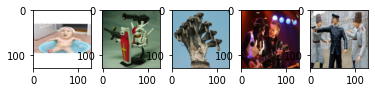

In [13]:
fig = plt.figure()
for i, I in enumerate(Is[:5]):
    ax = fig.add_subplot(1, 5, i + 1)
    ax.imshow(I.permute(1, 2, 0))

In [14]:
if not os.path.exists(f"{AE_RESULT_DIR}history.png") or RETRAIN_AUTOENCODER:
    autoencoder = Autoencoder(image_feature_dim = AE_FEATURE_DIM)

    # 学習履歴がある場合，途中から再開する
    if os.path.exists(f"{AE_RESULT_DIR}history.json"):
        with open(f"{AE_RESULT_DIR}history.json", "r") as f:
            a = json.load(f)
            train_loss_history = a["train_loss"]
            test_loss_history = a["test_loss"]
        autoencoder.load_state_dict(torch.load(f"{AE_RESULT_DIR}model_{len(train_loss_history):03}.pth"))
        START_EPOCH = len(train_loss_history)
    else:
        train_loss_history = []
        test_loss_history = []
        START_EPOCH = 0

    device = "cuda" if torch.cuda.is_available() else "cpu"
    autoencoder.to(device)
    optimizer = optim.AdamW(autoencoder.parameters(), lr = AE_LEARNING_RATE)

    train_image_dataloader = make_image_dataloader(train_image_paths, batch_size = AE_BATCH_SIZE, num_workers = NUM_WORKERS)
    test_image_dataloader = make_image_dataloader(test_image_paths, batch_size = AE_BATCH_SIZE, num_workers = NUM_WORKERS)

    # 1イテレーション学習する関数
    def train_step_for_autoencoder(autoencoder, optimizer, images):
        optimizer.zero_grad()
        outputs = autoencoder(images)
        loss = nn.MSELoss()(outputs, images)
        loss.backward()
        optimizer.step()
        return loss.item()

    # 1イテレーション検証する関数
    def test_step_for_autoencoder(model, images):
        with torch.no_grad():
            outputs = autoencoder(images)
            loss = nn.MSELoss()(outputs, images)
        return loss.item()

    for epoch in range(START_EPOCH, AE_EPOCH):

        # train
        train_loss_obj = 0.0
        autoencoder.train()
        pb = tqdm(train_image_dataloader, desc = f"Epoch {epoch+1}/{AE_EPOCH}")
        
        for images, _ in pb:
            images = images.float().to("cuda")

            loss = train_step_for_autoencoder(autoencoder, optimizer, images)
            train_loss_obj += loss
            pb.set_postfix({"train_loss": train_loss_obj / (pb.n + 1),})
            break
        train_loss = train_loss_obj / len(train_image_dataloader)

        # test
        test_loss_obj = 0.0
        autoencoder.eval()
        pb = tqdm(test_image_dataloader, desc = f"Epoch {epoch+1}/{AE_EPOCH}")
        
        for images, _ in pb:
            images = images.to(device)

            loss = test_step_for_autoencoder(autoencoder, images)
            test_loss_obj += loss
            pb.set_postfix({"test_loss": test_loss_obj / (pb.n + 1),})
            break
        test_loss = test_loss_obj / len(test_image_dataloader)

        print(f"Epoch: {epoch+1}/{AE_EPOCH}, "
            f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
        print("-" * 25)

        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)

        torch.save(autoencoder.state_dict(), f"{AE_RESULT_DIR}model_{len(train_loss_history):03}.pth")
        if os.path.exists(f"{AE_RESULT_DIR}model_{len(train_loss_history) - 1:03}.pth"):
            os.remove(f"{AE_RESULT_DIR}model_{len(train_loss_history) - 1:03}.pth")

        # 検証誤差を更新した場合、重みを保存
        if min(test_loss_history) == test_loss:
            torch.save(autoencoder.state_dict(), f"{AE_RESULT_DIR}best_model.pth")

        # 学習結果を保存
        with open(f"{AE_RESULT_DIR}history.json", "w") as f:
            json.dump({
                "train_loss": train_loss_history,
                "test_loss": test_loss_history,
            }, f)

        predict_by_autoencoder(autoencoder, test_image_paths[:5])

    # 学習結果を描画
    fig = plt.figure(figsize = (5, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(train_loss_history, label = "train")
    ax.plot(test_loss_history, label = "test")
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")
    ax.legend()
    ax.grid()

    fig.savefig(f"{AE_RESULT_DIR}history.png")

<ipython-input-14-73793d91efc4>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(f"{AE_RESULT_DIR}model_{len(train_loss_history):03}.

num data: 228908
num data: 25435


Epoch 2/25:   0%|          | 0/795 [00:00<?, ?it/s, test_loss=0.0841]


Epoch: 2/25, Train Loss: 0.0000, Test Loss: 0.0001
-------------------------


KeyboardInterrupt: 

In [14]:
# データセットの作成
if not os.path.exists(f"{RESULT_DIR}index_to_word.json") or RESET_DATA:
    # tokenizer
    with open('Japanese_BPEEncoder_V2/ja-swe32kfix.txt') as f:
        bpe = f.read().split('\n')

    with open('Japanese_BPEEncoder_V2/emoji.json') as f:
        emoji = json.loads(f.read())

    tokenizer = SWEEncoder_ja(bpe, emoji)

    tmp = list()
    word_count_dict = dict()

    for JP in tqdm(os.listdir(DATA_DIR)):
        
        N = int(JP.split(".")[0])

        with open(f"{DATA_DIR}{JP}", "r") as f:
            a = json.load(f)
        
        image_information = a["image_information"]
        is_photographic_probability = image_information["is_photographic_probability"]
        ocr = image_information["ocr"]

        # 現実写真以外を除去
        if not USE_UNREAL_IMAGE:
            if is_photographic_probability < 0.8: continue
            
        # 文字のある画像を除去
        if not USE_WORD_IMAGE:
            if len(ocr) != 0: continue
        
        bokes = a["bokes"]

        for B in bokes:
            # 星が既定の数以下の大喜利を除去
            if B["star"] < MIN_STAR:
                continue

            # 固有名詞を含む大喜利を除去
            if not USE_UNIQUE_NOUN_BOKE:
                if len(B["unique_nouns"]) != 0: continue

            tokenized_boke = tokenizer.encode(B["boke"])
            # 単語数が既定の数でない大喜利を除去
            if not MIN_SENTENCE_LENGTH <= len(tokenized_boke) < MAX_SENTENCE_LENGTH:
                continue

            for W in tokenized_boke:
                try:
                    word_count_dict[W] += 1
                except:
                    word_count_dict[W] = 1
            
            tmp.append({
                "image_number": N,
                "tokenized_boke": tokenized_boke
            })

    # 単語の最小出現回数を満たさない大喜利を除去
    boke_datas = list()
    words = list()

    for D in tqdm(tmp):
        flag = False
        for W in D["tokenized_boke"]:
            if word_count_dict[W] < MIN_APPER_WORD:
                flag = True
                break
        if flag: 
            continue
        
        boke_datas.append({
            "image_number": D["image_number"],
            "tokenized_boke": D["tokenized_boke"]
        })
        words += D["tokenized_boke"]
    words = set(words)
    image_numbers = list(set([D["image_number"] for D in boke_datas]))
    del tmp

    # tokenize
    index_to_index = dict()

    c = 3
    for D in tqdm(boke_datas):
        tmp = list()
        for W in D["tokenized_boke"]:
            try:
                index_to_index[W]
            except:
                index_to_index[W] = c
                c += 1
            tmp.append(index_to_index[W])
        D["tokenized_boke"] = [1] + tmp + [2]

    index_to_word = {
        V: tokenizer.decode([K]) for K, V in index_to_index.items()
    }
    index_to_word[0] = "<PAD>"
    index_to_word[1] = "<START>"
    index_to_word[2] = "<END>"

    #
    train_boke_datas, test_boke_datas = train_test_split(boke_datas, test_size = 0.01)

    with open(f"{RESULT_DIR}train_boke_datas.json", "w") as f:
        json.dump(train_boke_datas, f)
    with open(f"{RESULT_DIR}test_boke_datas.json", "w") as f:
        json.dump(test_boke_datas, f)
    with open(f"{RESULT_DIR}index_to_word.json", "w") as f:
        json.dump(index_to_word, f)

else:
    with open(f"{RESULT_DIR}train_boke_datas.json", "r") as f:
        train_boke_datas = json.load(f)
    with open(f"{RESULT_DIR}test_boke_datas.json", "r") as f:
        test_boke_datas = json.load(f)
    with open(f"{RESULT_DIR}index_to_word.json", "r") as f:
        index_to_word = json.load(f)

    image_numbers = [D["image_number"] for D in train_boke_datas] + [D["image_number"] for D in test_boke_datas]
    image_numbers = list(set(image_numbers))

print(f"学習に用いる大喜利の数: {len(train_boke_datas)}\n", 
      f"検証に用いる大喜利の数: {len(test_boke_datas)}\n",
      f"使用する画像の数: {len(image_numbers)}\n",
      f"単語の種類: {len(index_to_word)}")

学習に用いる大喜利の数: 2030920
 検証に用いる大喜利の数: 20515
 使用する画像の数: 244286
 単語の種類: 16705


In [ ]:
# 画像を特徴量に変換する
if RETRAIN_AUTOENCODER:
    shutil.rmtree(IMAGE_FEATURE_DIR) 
    os.mkdir(IMAGE_FEATURE_DIR)

tmp = list()
for IN in tqdm(image_numbers):
    if os.path.exists(f"{IMAGE_FEATURE_DIR}{IN}.npy"):
        continue
    tmp.append(f"{IMAGE_DIR}{IN}.jpg")

if len(tmp) != 0:
    image_dataloader = make_image_dataloader(tmp, batch_size = 128, num_workers = NUM_WORKERS)

    # encoder of Autoencoder
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    autoencoder = Autoencoder(image_feature_dim = AE_FEATURE_DIM)
    autoencoder.load_state_dict(torch.load(f"{AE_RESULT_DIR}best_model.pth"))
    model = autoencoder.encoder
    model = model.to(device)
    model.eval()

    for Is, IPs in tqdm(image_dataloader):
        Is = Is.to(device)
        features = model(Is).detach().cpu().numpy()

        for f, IP in zip(features, IPs):
            N = IP.split("/")[-1].split(".")[0]
            np.save(f"{IMAGE_FEATURE_DIR}{N}", f)

In [15]:
# 大喜利生成AIの学習用データローダを作る関数
def make_dataloader(boke_datas, max_sentence_length, num_workers = 4):
    """
        boke_datas: {"image_number":画像のお題番号 ,"tokenized_boke":トークナイズされた大喜利}からなるリスト
        max_sentence_length: 学習データの最大単語数(<START>, <END>トークンを含まない)
        num_workers: データローダが使用するCPUのスレッド数
    """
    class SentenceGeneratorDataset(Dataset):
        def __init__(self, image_file_numbers, sentences, teacher_signals):
            """
                image_file_numbers: 画像の番号からなるリスト
                sentences: 入力文章からなるリスト
                teacher_signals: 教師信号からなるリスト
            """
            if len(image_file_numbers) != len(sentences) and len(teacher_signals) != len(sentences):
                raise ValueError("データリストの長さが一致しません")

            self.image_file_numbers = image_file_numbers
            self.sentences = sentences
            self.teacher_signals = teacher_signals

        def __len__(self):
            return len(self.teacher_signals)

        def __getitem__(self, idx):
            image_feature = np.load(f"{IMAGE_FEATURE_DIR}{self.image_file_numbers[idx]}.npy")
            sentence = self.sentences[idx]
            teacher_signal = self.teacher_signals[idx]

            return image_feature, sentence, teacher_signal

    def collate_fn_tf(batch):
        image_features = torch.tensor(np.array([B[0] for B in batch]))
        sentences = torch.tensor(np.array([B[1] for B in batch]))
        teacher_signals = torch.tensor(np.array([B[2] for B in batch]))

        return image_features, sentences, teacher_signals

    image_file_numbers = list()
    sentences = list()
    teacher_signals = list()

    for D in tqdm(boke_datas):
        image_file_numbers.append(D["image_number"])
        tmp = D["tokenized_boke"] + [0] * (2 + max_sentence_length - len(D["tokenized_boke"]))
        sentences.append(tmp[:-1])
        teacher_signals.append(tmp[1:])

    dataset = SentenceGeneratorDataset(image_file_numbers, sentences, teacher_signals)
    dataloader = DataLoader(
        dataset, 
        batch_size = BATCH_SIZE, 
        num_workers = num_workers, 
        collate_fn = collate_fn_tf
    )

    print(f"num data: {len(teacher_signals)}")

    return dataloader

In [21]:
# 大喜利生成モデルのクラス
class BokeGeneratorModel(nn.Module):
    def __init__(self, num_word, image_feature_dim, sentence_length, feature_dim = 1024):
        """
            num_word: 学習に用いる単語の総数
            image_feature_dim: 画像の特徴量の次元数
            sentence_length: 入力する文章の単語数
            feature_dim: 特徴量次元数
        """
        super(BokeGeneratorModel, self).__init__()
        self.num_word = num_word
        self.image_feature_dim = image_feature_dim
        self.sentence_length = sentence_length
        self.feature_dim = feature_dim
        
        self.fc1 = nn.Linear(image_feature_dim, feature_dim)
        self.embedding = nn.Embedding(num_word, feature_dim, padding_idx = 0)
        self.lstm = nn.LSTM(input_size = feature_dim, hidden_size = feature_dim, 
                            batch_first = True)
        self.fc2 = nn.Linear(feature_dim + feature_dim, 2 * feature_dim)
        self.fc3 = nn.Linear(2 * feature_dim, 2 * feature_dim)
        self.fc4 = nn.Linear(2 * feature_dim, num_word)
    
    # LSTMの初期値は0で，画像の特徴量と文章の特徴量を全結合層の前で結合する
    def forward(self, image_features, sentences):
        """
            image_features: 画像の特徴量
            sentences: 入力する文章
        """
        x1 = F.leaky_relu(self.fc1(image_features))
        x1 = x1.unsqueeze(1).repeat(1, self.sentence_length, 1)

        x2 = self.embedding(sentences)
        x2, _ = self.lstm(x2)

        x = torch.cat((x1, x2), dim = -1)
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))

        return self.fc4(x)

In [ ]:
# 文章生成の精度を計算する関数
def calculate_accuracy(teacher_signals, outputs):
    """
        teacher_signals: 教師信号
        outputs: モデルの出力
    """
    _, predicted_words = outputs.max(dim = -1)
    # パディングに対して精度を計算しない
    mask = (teacher_signals != 0)
    correct = ((predicted_words == teacher_signals) & mask).sum().item()
    total = mask.sum().item()
    accuracy = correct / total if total > 0 else 0.0
    return accuracy

# 1イテレーション学習する関数
def train_step(model, optimizer, batch_data, batch_labels):
    optimizer.zero_grad()
    outputs = model(*batch_data)
    # パディングに対して損失を計算しない
    loss = F.cross_entropy(outputs.view(-1, outputs.size(-1)), batch_labels.view(-1),
                           ignore_index = 0)
    accuracy = calculate_accuracy(batch_labels, F.softmax(outputs, dim = -1))
    loss.backward()
    optimizer.step()
    return loss.item(), accuracy

# 1イテレーション検証する関数
def evaluate(model, batch_data, batch_labels):
    with torch.no_grad():
        outputs = model(*batch_data)
        loss = F.cross_entropy(outputs.view(-1, outputs.size(-1)), batch_labels.view(-1),
                               ignore_index = 0)
        accuracy = calculate_accuracy(batch_labels, F.softmax(outputs, dim = -1))
    return loss.item(), accuracy

In [16]:
train_dataloader = make_dataloader(train_boke_datas, max_sentence_length = MAX_SENTENCE_LENGTH, num_workers = NUM_WORKERS)

100%|██████████| 2030920/2030920 [00:05<00:00, 376869.21it/s]

num data: 2030920


In [17]:
IF, S, T = next(iter(train_dataloader))

In [18]:
IF

tensor([[ 1.1265e+00,  5.4682e-01, -2.6377e-03,  ...,  1.2396e+00,
          7.9547e-01,  8.7314e-01],
        [ 2.0829e+00,  2.1133e+00, -4.2770e-03,  ..., -7.7618e-03,
         -2.4371e-03,  1.7146e+00],
        [ 1.0221e+00, -2.7735e-03,  3.3475e-01,  ...,  1.1960e+00,
         -1.9723e-02,  1.2980e+00],
        ...,
        [ 3.0247e+00,  5.6076e-01,  4.3437e+00,  ..., -1.5713e-02,
         -1.9582e-02, -3.1424e-03],
        [ 9.3699e-01,  6.0997e-01,  1.5403e+00,  ...,  2.6746e+00,
         -1.0381e-02,  7.8680e-01],
        [ 2.4179e+00,  1.4890e+00, -9.4017e-03,  ..., -1.0710e-02,
         -5.7778e-02, -3.8969e-03]])

In [ ]:
train_dataloader = make_dataloader(train_boke_datas, max_sentence_length = MAX_SENTENCE_LENGTH, num_workers = NUM_WORKERS)
test_dataloader = make_dataloader(test_boke_datas, max_sentence_length = MAX_SENTENCE_LENGTH, num_workers = NUM_WORKERS)

model = BokeGeneratorModel(num_word = len(index_to_word), 
                           image_feature_dim = AE_FEATURE_DIM, 
                           sentence_length = MAX_SENTENCE_LENGTH + 1, 
                           feature_dim = FEATURE_DIM)

# 学習履歴がある場合，途中から再開する
if os.path.exists(f"{RESULT_DIR}history.json"):
    with open(f"{RESULT_DIR}history.json", "r") as f:
        a = json.load(f)
        train_loss_history = a["train_loss"]
        train_accuracy_history = a["train_accuracy"]
        test_loss_history = a["test_loss"]
        test_accuracy_history = a["test_accuracy"]
    model.load_state_dict(torch.load(f"{RESULT_DIR}model_{len(train_loss_history):03}.pth"))
    SATRT_EPOCH = len(train_loss_history)
else:
    train_loss_history = []
    train_accuracy_history = []
    test_loss_history = []
    test_accuracy_history = []
    SATRT_EPOCH = 0

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr = LEARNING_RATE)

In [ ]:
for epoch in range(SATRT_EPOCH, EPOCH):

    # train
    train_loss_obj = 0.0
    train_accuracy_obj = 0.0
    model.train()
    pb = tqdm(train_dataloader, desc = f"Epoch {epoch+1}/{EPOCH}")
    
    for image_features, sentences, teacher_signals in pb:
        image_features = image_features.to(device)
        sentences = sentences.to(device)
        teacher_signals = teacher_signals.to(device)
        
        loss, accuracy = train_step(model, optimizer, (image_features, sentences), teacher_signals)
        train_loss_obj += loss
        train_accuracy_obj += accuracy
        pb.set_postfix({"train_loss": train_loss_obj / (pb.n + 1), "train_accuracy": train_accuracy_obj / (pb.n + 1)})
        break
    train_loss = train_loss_obj / len(train_dataloader)
    train_accuracy = train_accuracy_obj / len(train_dataloader)

    # test
    test_loss_obj = 0.0
    test_accuracy_obj = 0.0
    model.eval()
    pb = tqdm(test_dataloader, desc = "Evaluating")

    for image_features, sentences, teacher_signals in pb:
        image_features = image_features.to(device)
        sentences = sentences.to(device)
        teacher_signals = teacher_signals.to(device)

        loss, accuracy = evaluate(model, (image_features, sentences), teacher_signals)
        test_loss_obj += loss
        test_accuracy_obj += accuracy
        pb.set_postfix({"test_loss": test_loss_obj / (pb.n + 1), "test_accuracy": test_accuracy_obj / (pb.n + 1)})
        break
    test_loss = test_loss_obj / len(test_dataloader)
    test_accuracy = test_accuracy_obj / len(test_dataloader)

    print(f"Epoch: {epoch+1}/{EPOCH}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    print("-" * 25)

    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)
    test_loss_history.append(test_loss)
    test_accuracy_history.append(test_accuracy)

    torch.save(model.state_dict(), f"{RESULT_DIR}model_{len(train_loss_history):03}.pth")
    if os.path.exists(f"{RESULT_DIR}model_{len(train_loss_history) - 1:03}.pth"):
        os.remove(f"{RESULT_DIR}model_{len(train_loss_history) - 1:03}.pth")

    # 学習精度を更新した場合、重みを保存
    if max(train_accuracy_history) == train_accuracy:
        torch.save(model.state_dict(), f"{RESULT_DIR}best_model.pth")
    
    # 学習結果を保存
    with open(f"{RESULT_DIR}history.json", "w") as f:
        json.dump({
            "train_loss": train_loss_history,
            "train_accuracy": train_accuracy_history,
            "test_loss": test_loss_history,
            "test_accuracy": test_accuracy_history
        }, f)

In [ ]:
# 学習結果を描画
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(train_loss_history, label = "train")
ax.plot(test_loss_history, label = "test")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.legend()
ax.grid()

ax = fig.add_subplot(1, 2, 2)
ax.plot(train_accuracy_history, label = "train")
ax.plot(test_accuracy_history, label = "test")
ax.set_xlabel("epoch")
ax.set_ylabel("accuracy")
ax.legend()
ax.grid()

fig.savefig(f"{RESULT_DIR}history.png")

In [23]:
# 大喜利生成AI
class NeuralJokingMachine:
    def __init__(self, weight_path, ae_weight_path, index_to_word, sentence_length, feature_dim = 1024, ae_feature_dim = 16384):
        """
            weight_path: 大喜利適合判定モデルの学習済みの重みのパス
            ae_weight_path: 
            index_to_word: 単語のID: 単語の辞書(0:<PAD>, 1:<START>, 2:<END>)
            sentence_length: 入力する文章の単語数
            feature_dim: 特徴量次元数
            ae_feature_dim: 
        """
        self.index_to_word = index_to_word
        self.sentence_length = sentence_length

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.boke_generate_model = BokeGeneratorModel(
                                        num_word = len(index_to_word), 
                                        image_feature_dim = ae_feature_dim, 
                                        sentence_length = sentence_length, 
                                        feature_dim = feature_dim)
        self.boke_generate_model.load_state_dict(torch.load(weight_path))
        self.boke_generate_model.to(self.device)
        self.boke_generate_model.eval()

        self.autoencoder = Autoencoder(image_feature_dim = ae_feature_dim)
        self.autoencoder.load_state_dict(torch.load(ae_weight_path))
        self.encoder = self.autoencoder.encoder
        self.encoder = self.encoder.to(self.device)
        self.encoder.eval()

        # 画像の前処理
        self.image_preprocesser = transforms.Compose([
            transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
            transforms.ToTensor(),
        ])
    
    def __call__(self, image_path, argmax = False, top_k = 5):
        """
            image_path: 大喜利を生成したい画像のパス
            argmax: Trueなら最大確率の単語を選ぶ, FalseならTop-Kサンプリングを行う
            top_k: Top-Kサンプリング時に考慮する単語の数
        """
        image = Image.open(image_path)
        preprocessed_image = self.image_preprocesser(image).to(self.device)
        image_feature = self.encoder( preprocessed_image.unsqueeze(0) ) # (1, 2048)
        
        generated_text = [1] # <START>トークン
        for i in range(1, self.sentence_length):
            tmp = generated_text + [0] * (self.sentence_length - i) # Padding
            tmp = torch.Tensor(np.array(tmp)).unsqueeze(0).to(self.device).to(dtype=torch.int32) # (1, sentence_length)
            pred = self.boke_generate_model(image_feature, tmp) # (1, sentence_length, num_word)
            target_pred = pred[0][i - 1]

            if argmax:
                # 最大確率の単語を選ぶ
                chosen_id = torch.argmax(target_pred).item()
            else:
                # Top-Kサンプリング
                top_k_probs, top_k_indices = torch.topk(target_pred, top_k)
                top_k_probs = torch.nn.functional.softmax(top_k_probs, dim = -1)
                chosen_id = np.random.choice(top_k_indices.detach().cpu().numpy(), 
                                             p = top_k_probs.detach().cpu().numpy())
            
            generated_text.append(chosen_id)
            if chosen_id == 2:
                break
        
        generated_sentence = ""
        for I in generated_text[1:-1]:
            generated_sentence += self.index_to_word[I]
        return generated_sentence

In [27]:
model = NeuralJokingMachine(weight_path = f"{RESULT_DIR}best_model.pth",
                    ae_weight_path = f"{AE_RESULT_DIR}best_model.pth",
                    index_to_word = {
                        int(K): V for K, V in index_to_word.items()
                    },
                    sentence_length = 32, 
                    feature_dim = 1024, 
                    ae_feature_dim = 16384)

<ipython-input-23-e5c4766616ca>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.boke_generate_model.load_state_dict(torch.load(weight_path))
<ipython-input-23-e5c4766

In [29]:
f"{AE_RESULT_DIR}best_model.pth"

'../../results/Autoencoder/False_False_False_0_32_4_31_128_128_25_32_0.0001_16384/best_model.pth'

In [30]:
f"{RESULT_DIR}best_model.pth"

'../../results/GUMI_AE/False_False_False_0_32_4_31_128_128_25_32_0.0001_16384_25_512_0.001_1024/best_model.pth'

In [28]:
model("../Line_Bot/tmp.jpg")

'この中に間違った文字を発見しました！'